
# Exoplanet Classification Project 

Outline of this notebook


1. [Introduction](#introduction)
2. [Dataset](#dataset)
3. [Data Exploration](#data-exploration)
    3.1 Initial Columns Cleaning
4. [Data Preprocessing](#data-preprocessing)
5. [Model Building](#model-building)
6. [Model Evaluation](#model-evaluation)
7. [Conclusion](#conclusion)
8. [References](#references)

![GIFurl](https://media.giphy.com/media/YP2ka5SH2MzpjZvIXB/giphy-downsized.gif "gif")

------------------------------------------------------------------------------------------------------

<a id='introduction'></a>

## 1. Introduction
In this project, we will explore the classification of exoplanets using various machine learning techniques. Exoplanets are planets that orbit stars outside our solar system. The goal of this project is to build a model that can accurately classify weather a Kepler object is an exoplanet based on their recorded features.

#### Imports

In [3]:
import pandas as pd
import os
import xml.etree.ElementTree as ET, urllib.request, gzip, io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #missing values plot


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek

------------------------------------------------------------------------------------------------------

<a id='dataset'></a>

## 2. Dataset
We will be using the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html), specifically the [Kepler Objects of Interest (KOIs)](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative) dataset for this project. This dataset contains information about confirmed exoplanets as well as false positives. It includes features such as orbital period, transit depth, planet radius, and more. The target variable is the exoplanet classification, which can be either "Confirmed", "Candidate" or "False Positive". The dataset is updated regularlly.

A snapshot of the table should be saved near the code, here we will load the csv into a dataframe.

#https://drive.google.com/file/d/1WfxroJ_5XD5NE14ZAM4GvsUWoLgI0k1v/view?usp=share_link

In [4]:
nasa_df = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv', skiprows=144)
nasa_df.set_index('rowid', inplace=True)

In [5]:
print("There are " + str(nasa_df.shape[0]) + " rows in the NASA data")
print("There are " + str(nasa_df.shape[1]) + " columns in the NASA data")

There are 9564 rows in the NASA data
There are 140 columns in the NASA data


As we can see in the raw data there are 9,564 rows and 140 columns.

We'll print a few rows, and information about the columns in order to see which are numeric or categorical.

In [6]:
# Print the shape of the dataset
print(nasa_df.shape)

#print first 5 rows of the dataset
nasa_df.head()

(9564, 140)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [7]:
# Analysing type of data
nasa_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9564 entries, 1 to 9564
Data columns (total 140 columns):
 #    Column              Dtype  
---   ------              -----  
 0    kepid               int64  
 1    kepoi_name          object 
 2    kepler_name         object 
 3    koi_disposition     object 
 4    koi_vet_stat        object 
 5    koi_vet_date        object 
 6    koi_pdisposition    object 
 7    koi_score           float64
 8    koi_fpflag_nt       int64  
 9    koi_fpflag_ss       int64  
 10   koi_fpflag_co       int64  
 11   koi_fpflag_ec       int64  
 12   koi_disp_prov       object 
 13   koi_comment         object 
 14   koi_period          float64
 15   koi_period_err1     float64
 16   koi_period_err2     float64
 17   koi_time0bk         float64
 18   koi_time0bk_err1    float64
 19   koi_time0bk_err2    float64
 20   koi_time0           float64
 21   koi_time0_err1      float64
 22   koi_time0_err2      float64
 23   koi_eccen           float64
 24   ko

------------------------------------------------------------------------------------------------------

# 3. Data Exploration 

3.1. Feature Importance 

3.2. 

3.3. Visualize the distribution of the target variable.

3.4. Explore the relationship between the features and the target variable.

------------------------------------------------------------------------------------------------------

<a id='data-exploration'></a>

# 4. Data Preprocessing
Before we start building our classification model, let's first explore the dataset. We will perform the following steps:

4.1. [Initial Feature Cleaning](#column-cleaning)

    - Rename columns.
    - Create target column.
    - Remove irrelevant columns.
    - Remove error columns.
    - Encode categorical features.

4.2. [Handling Missing Values](#missing-values)

    - Drop columns that have more than 50% missing values.
    - Drop rows that have more than 50% missing values.
    - Impute missing values.
    
4.3. [Data Normalization](#normalization)

4.4. [PCA Outlier Detection](#outliers)

4.5. [Check for Correlated Features](#corr)

4.6. [Class Balancing](#balance)

4.7. [Feature Selection after SMOTE](#feature-selection)


<a id='column-cleaning'></a>
## 4.1. Initial Column Cleaning

### 4.1.1. Rename Columns
The column names in the loaded csv is an abbreviation of the full name, here we will load these names and rename the columns with the full feature name.

In [8]:
names = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv',skiprows=3, nrows=140, names=['full'])

names[['A', 'B']] = names['full'].str.split(':', 1, expand=True)
names[['AA', 'AAA']] = names['A'].str.split('COLUMN', 1, expand=True)

names.drop(columns=['full', 'A', 'AA'], inplace=True)
names.rename(columns={'B':'fullname',
                      'AAA':'currentname'}, inplace=True)
names = names.replace(' ', '', regex=True)

names.head()

C:\Users\Nareed\AppData\Local\Temp\ipykernel_17428\377690018.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  names[['A', 'B']] = names['full'].str.split(':', 1, expand=True)
C:\Users\Nareed\AppData\Local\Temp\ipykernel_17428\377690018.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  names[['AA', 'AAA']] = names['A'].str.split('COLUMN', 1, expand=True)


,fullname,currentname
0,KepID,kepid
1,KOIName,kepoi_name
2,KeplerName,kepler_name
3,ExoplanetArchiveDisposition,koi_disposition
4,VettingStatus,koi_vet_stat


In [9]:
renaming = {}
for i, r in names.iterrows():
    renaming[r.currentname] = r.fullname

#rename columns with their full name
nasa_df = nasa_df.rename(columns=renaming)
nasa_df.head()

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,VettingStatus,DateofLastParameterUpdate,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,StellarEclipseFalsePositiveFlag,...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec]
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


### 4.1.2. Create Target Column

We have two columns describing the disposition of a KOI:
* **Disposition Using Kepler Data**
  * This column describes whether a KOI [Kepler Object of Interest] is considered a candidate for an exoplanet, or a false positive, or a confirmed exoplanet.
*   **Exoplanet Archive Disposition** 
  * This column is similar to above, but it also incorporates newer peer-reviewed/published information from the Exoplanet Archive.

Since the second column includes a more fine grained disposition we will use it as our target.
We will create our target called '*ExoplanetConfirmed*' in the following manner:
- 0 if disposition is false positive or candidate.*italicized text*
- 1 if disposition is confirmed. 

In [10]:
nasa_df['ExoplanetArchiveDisposition'].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2671
CANDIDATE         2054
Name: ExoplanetArchiveDisposition, dtype: int64

In [11]:
nasa_df['ExoplanetConfirmed'] = nasa_df['ExoplanetArchiveDisposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

nasa_df.head(2)

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,VettingStatus,DateofLastParameterUpdate,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,StellarEclipseFalsePositiveFlag,...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec],ExoplanetConfirmed
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.16,0.20,0.17,0.08,0.13,0.31,0.17,0.32,0.16,1
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.48,0.39,0.36,0.49,0.34,0.12,0.73,0.50,0.45,1


### 4.1.3. Remove Irrelevant Columns

After the creation of the target class we can remove the other information we have about the kepler disposition, which includes the following columns:


*   **KepID** : id number of the kepler.
*   **KOIName** : the KOI name.
*   **KeplerName** : kepler name.
*   **ExoplanetArchiveDisposition** : the disposition described above.
*   **VettingStatus** : "ACTIVE" or "DONE". Active provides the latest information for follow-up observations, and the transition to "DONE" status occurs when all dispositions are finalized and model parameters are updated appropriately.
*   **DateofLastParameterUpdate** : date of when the keplet info was last updated.
*   **DispositionUsingKeplerData** : the disposition described above.
*   **DispositionScore** : A value between 0 and 1 that indicates the confidence in the KOI disposition.
*   **Comment** : A description of the reason why an object's disposition has been given as false positive.
*   **NotTransit-LikeFalsePositiveFlag** : A KOI whose light curve is not consistent with that of a transiting planet.
*   **DispositionProvenance** : Disposition Provenance



In [12]:
todrop = ['KepID', 'KOIName', 'KeplerName', 'ExoplanetArchiveDisposition', 'VettingStatus', 
        'DateofLastParameterUpdate', 'DispositionUsingKeplerData', 'DispositionScore',
        'Comment', 'NotTransit-LikeFalsePositiveFlag', 
        'DispositionProvenance']

nasa_df.drop(columns=todrop, inplace=True)

nasa_df.head(3)

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],OrbitalPeriodUpperUnc.[days],OrbitalPeriodLowerUnc.[days],TransitEpoch[BKJD],TransitEpochUpperUnc.[BKJD],TransitEpochLowerUnc.[BKJD],TransitEpoch[BJD],...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec],ExoplanetConfirmed
rowid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,9.488036,0.000028,-0.000028,170.538750,0.002160,-0.002160,2455003.539,...,0.16,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160,1
2,0,0,0,54.418383,0.000248,-0.000248,162.513840,0.003520,-0.003520,2454995.514,...,0.48,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450,1
3,0,0,0,19.899140,0.000015,-0.000015,175.850252,0.000581,-0.000581,2455008.850,...,0.07,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074,0


In [13]:
print("After removing unimportant columns we have:\n")
print("There are " + str(nasa_df.shape[0]) + " rows in the NASA data")
print("There are " + str(nasa_df.shape[1]) + " columns in the NASA data")

After removing unimportant columns we have:

There are 9564 rows in the NASA data
There are 130 columns in the NASA data


### 4.1.4. Remove Error Columns

Some columns are the errors margins of the calculations in other columns. We will remove these error columns

In [14]:
err_colummns = []

# go over cols and get every col with 'Unc.' in it
for c in nasa_df.columns:
    if 'Unc.' in c:
        err_colummns.append(c)


# finalize changes, but hold on to the data with error in case we need it later
data = nasa_df.drop(err_colummns, axis = 1)

print(f"\nDataset had {nasa_df.shape[1]} columns.\nIt now has {data.shape[1]} columns.")


Dataset had 130 columns.
It now has 72 columns.


### 4.1.5. Encoding Categorical Data



In [15]:
df_categorical = data.select_dtypes(object)

 Drop all columns that either contain 1 category, or contain too many categories.

In [16]:
df_categorical.drop(['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary', 'Quarters'], axis=1, inplace=True)

<h4><b> One-hot encode all categories. </b></h4>

In [17]:
#categorical data
categorical_cols = ['PlanetaryFitType', 'ParametersProvenance', 'TCEDelivery', 'StellarParameterProvenance'] 

#import pandas as pd
df_categorical = pd.get_dummies(df_categorical, columns = categorical_cols)
                                
df_categorical # We will merge this with the working DF and delete the categorical columns.

,PlanetaryFitType_LS,PlanetaryFitType_LS+MCMC,PlanetaryFitType_MCMC,PlanetaryFitType_none,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
rowid,,,,,,,,,,,,,,
1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
2,0,1,0,0,0,0,1,0,0,1,0,1,0,0
3,0,1,0,0,0,0,1,0,0,1,0,1,0,0
4,0,1,0,0,0,0,1,0,0,1,0,1,0,0
5,0,1,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,0,1,0,0,0,0,1,0,0,1,0,1,0,0
9561,0,1,0,0,0,0,1,0,0,1,0,1,0,0
9562,0,1,0,0,0,0,1,0,0,1,0,1,0,0


Drop all categorical data and concat the encoded ones

In [18]:
data.drop(categorical_cols + ['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary'], axis=1, inplace=True)
data = pd.concat([data, df_categorical], axis=1)

In [19]:
#Why do we drop these? 
data.drop(['Eccentricity', 'LimbDarkeningCoeff.4', 'LimbDarkeningCoeff.3', 'Quarters'], axis=1, inplace=True)

<a id='missing-values'></a>
## 4.2. Check & Handle Missing Values

First of all, we check how much missing values there are in the dataset.

<Axes: >

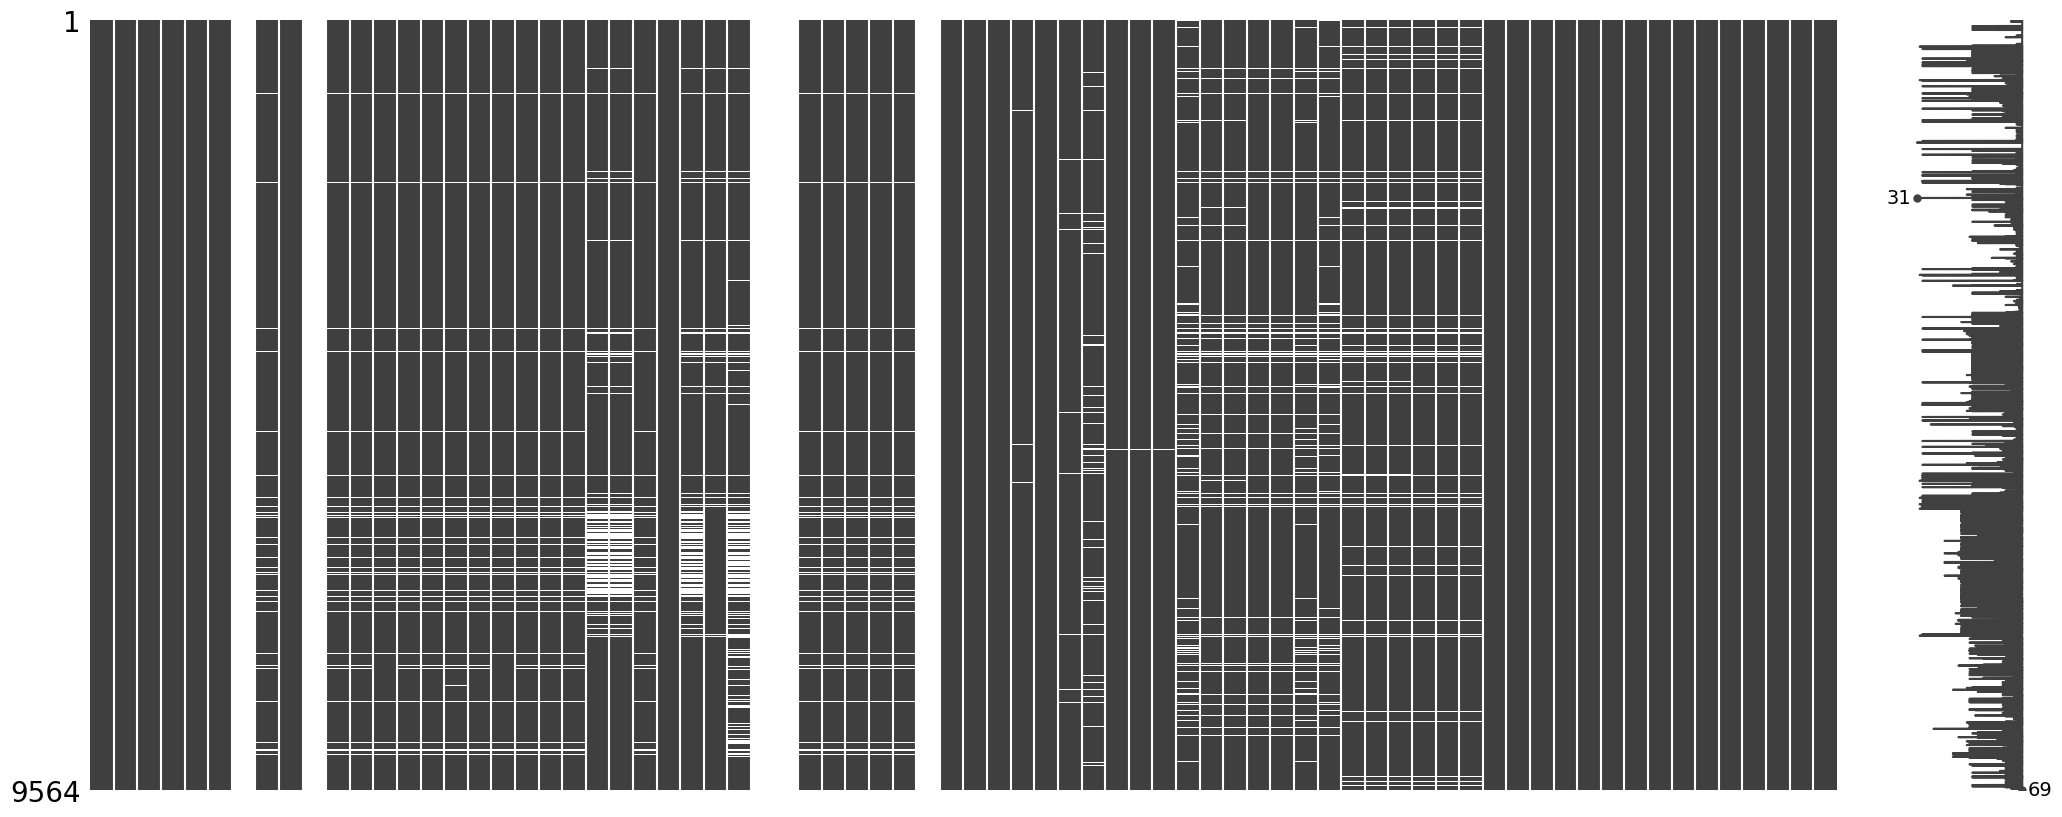

In [20]:
import missingno as msno
msno.matrix(pd.concat([data]))

### 4.2.1. Drop Columns with more than 50% missing values.

Here we dropped all columns that have more than 50% of their data missing.

<Axes: >

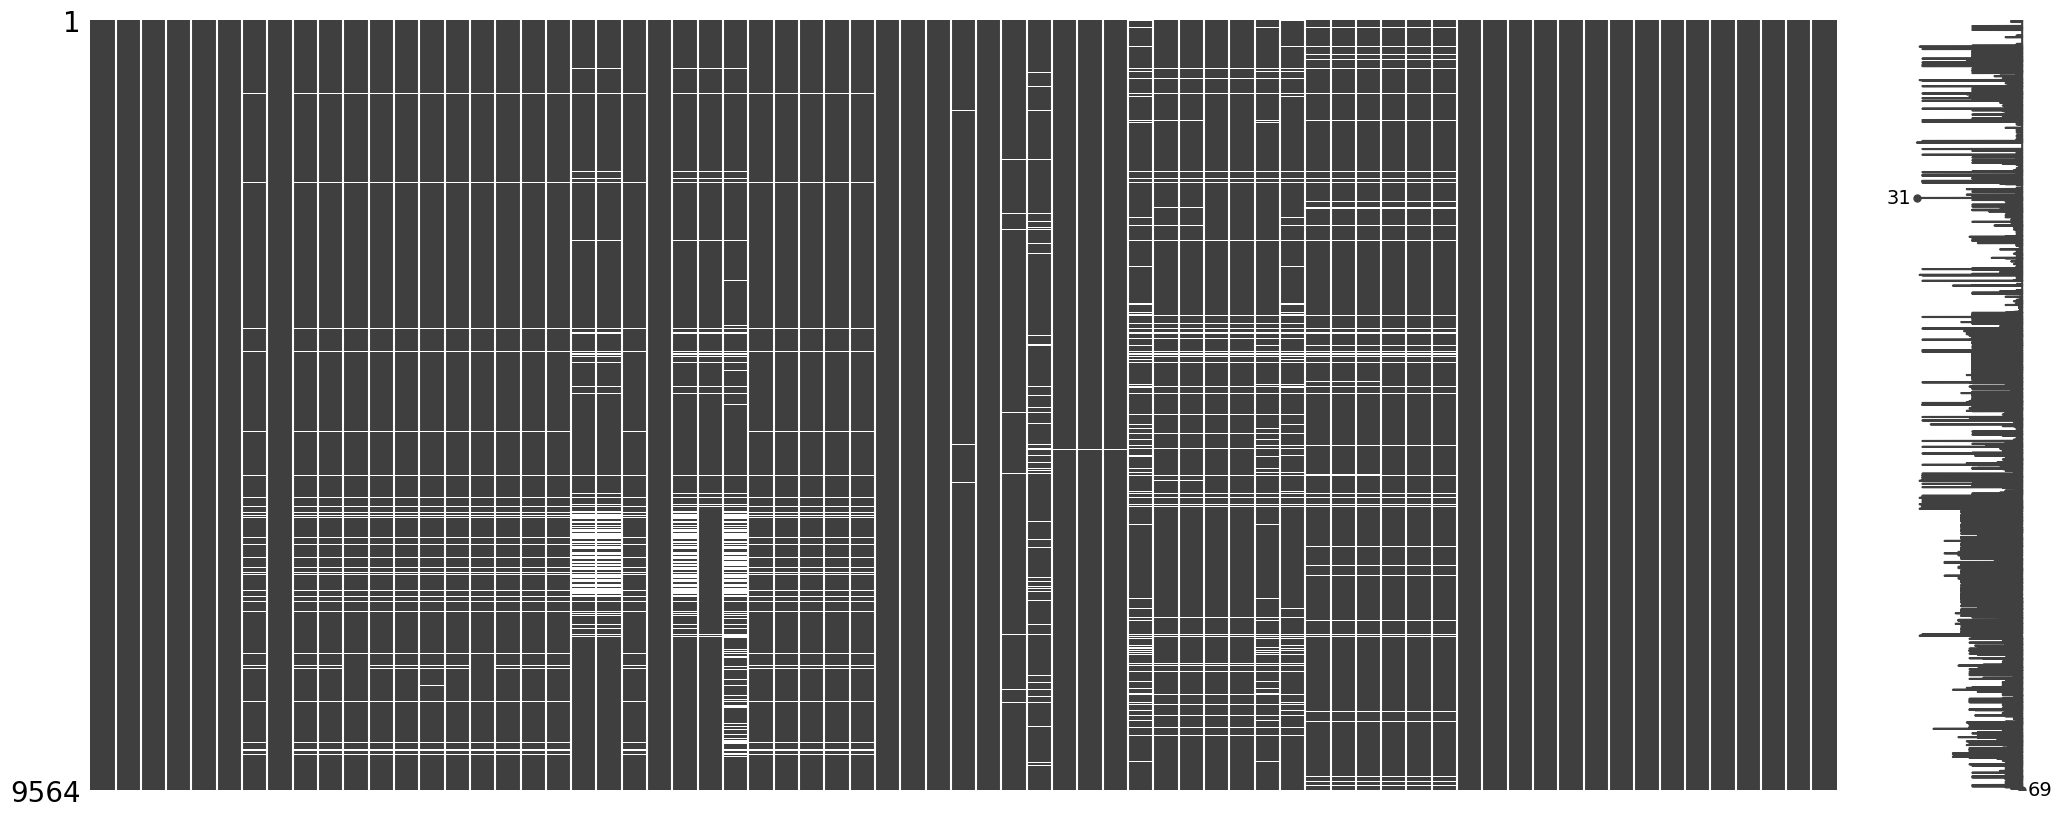

In [21]:
data = data.loc[:, data.isnull().mean() < .5]

msno.matrix(pd.concat([data]))

### 4.2.2. Drop Rows with 50%+ Missing Values

<Axes: >

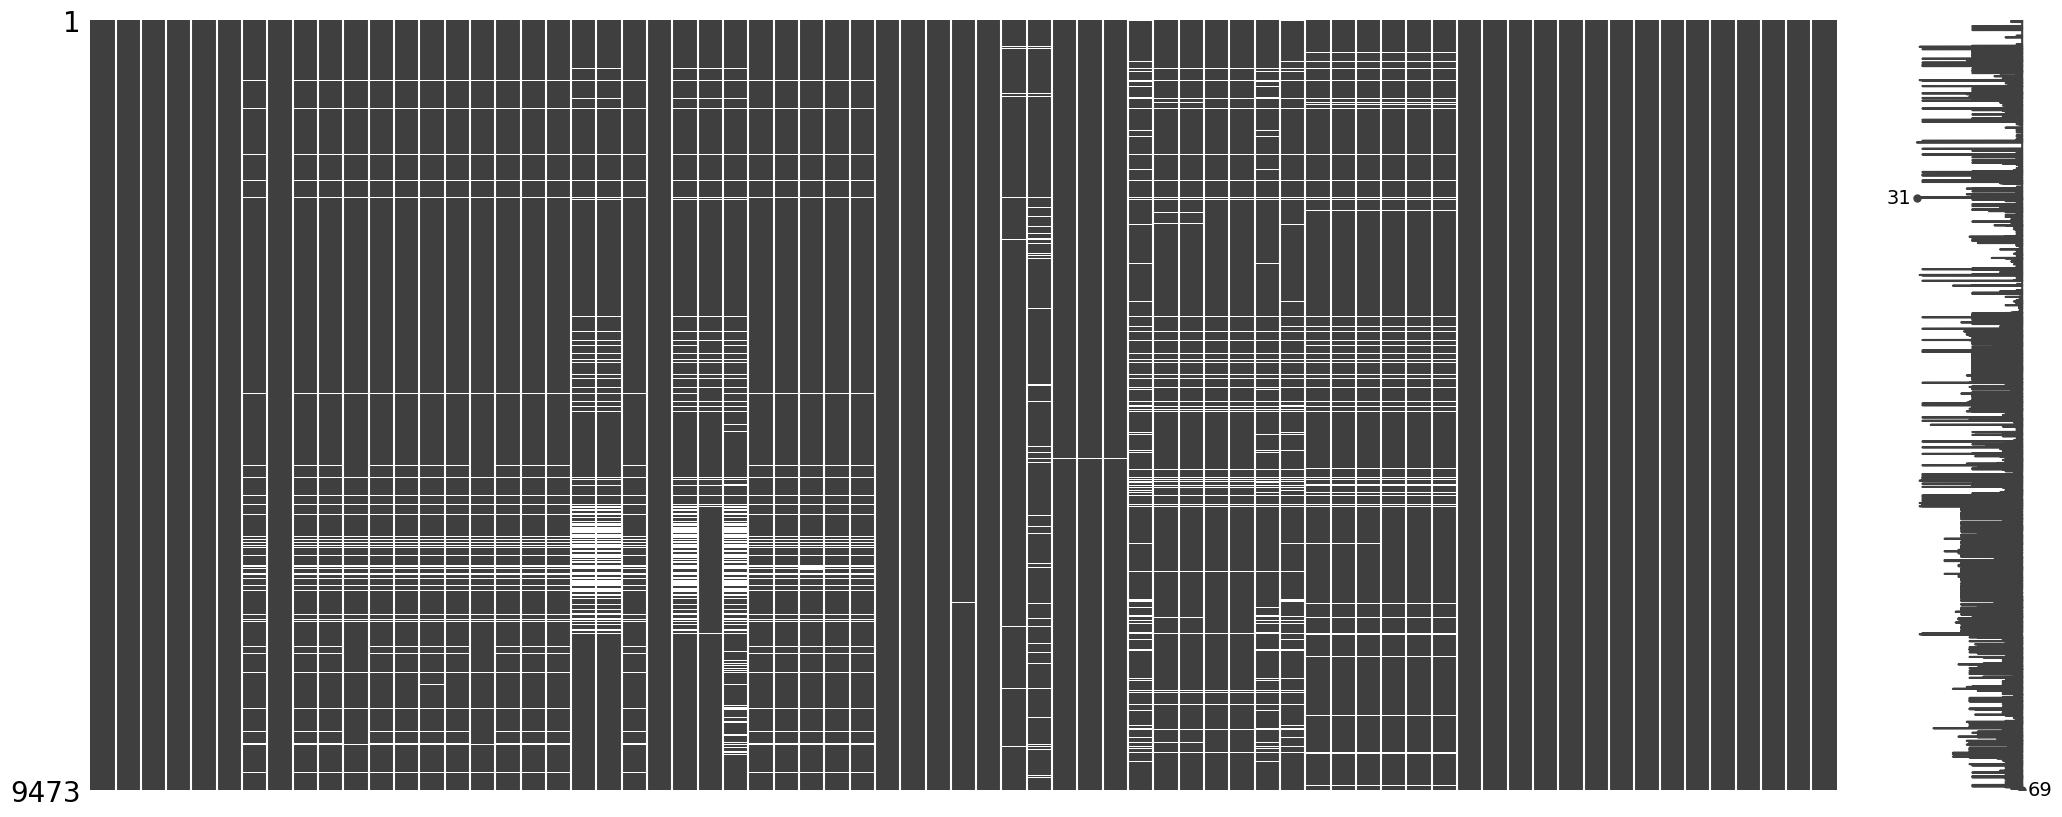

In [22]:
per_row = []
for index in range(len(data.index)) :
    per_row.append([index, data.iloc[index].isna().mean()])

row_missing = pd.DataFrame(per_row, columns=['index', 'missing']).sort_values(by='missing', ascending=False)

rows_to_delete = list(row_missing.loc[row_missing['missing'] > 0.5].index)
data = data.drop(rows_to_delete,axis='index')

msno.matrix(pd.concat([data]))

In [23]:
data.shape

(9473, 69)

### 4.2.3. Impute Missing Valuews

C:\Users\Nareed\AppData\Local\Temp\ipykernel_17428\1539705492.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)


<Axes: >

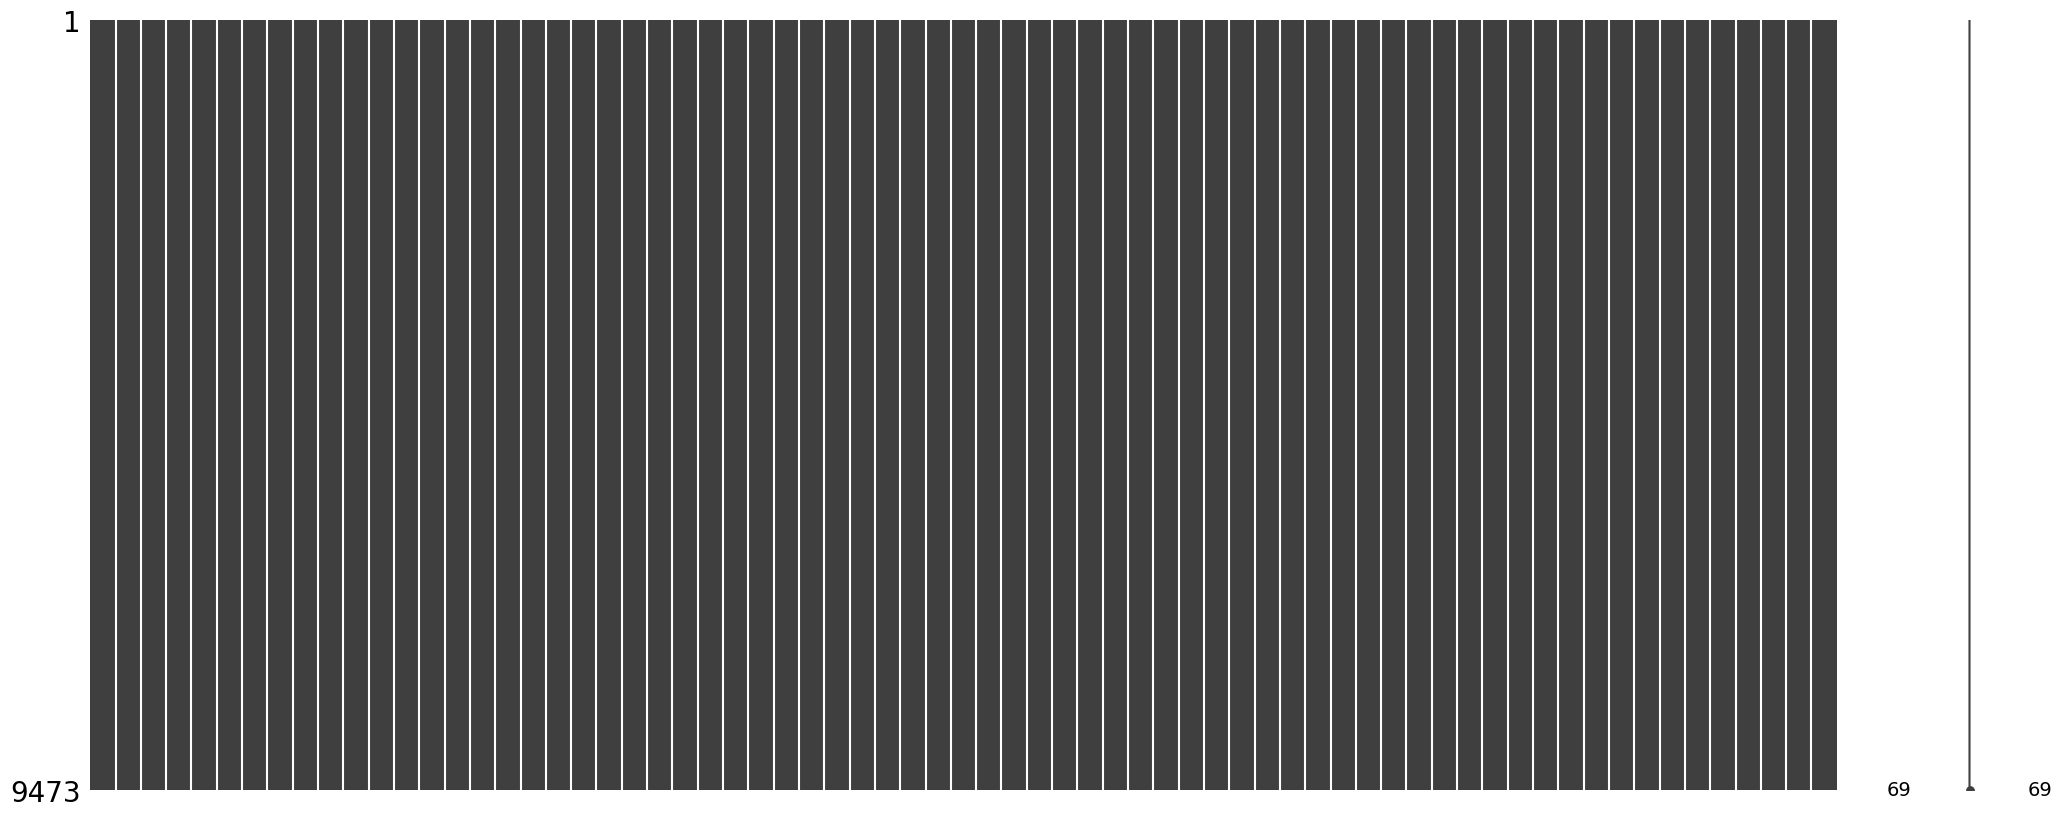

In [24]:
df_imputer_knn = data.copy(deep=True)

# Impute the feature
knnimputer = KNNImputer(n_neighbors=3)
df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)

msno.matrix(pd.concat([df_imputer_knn]))

In [30]:
df_imputer_knn

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
rowid,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,9.488036,170.538750,2455003.539,0.146,2.95750,615.8,0.022344,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,54.418383,162.513840,2454995.514,0.586,4.50700,874.8,0.027954,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,19.899140,175.850252,2455008.850,0.969,1.78220,10829.0,0.154046,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.736952,170.307565,2455003.308,1.276,2.40641,8079.2,0.387394,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,2.525592,171.595550,2455004.596,0.701,1.65450,603.3,0.024064,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,1.0,1.0,0.0,0.527699,131.705093,2454964.705,1.252,3.22210,1579.2,0.297633,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9561,0.0,0.0,0.0,1.739849,133.001270,2454966.001,0.043,3.11400,48.5,0.006379,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9562,0.0,1.0,0.0,0.681402,132.181750,2454965.182,0.147,0.86500,103.6,0.009444,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


<a id='normalization'></a>
## 4.3. Normalization

In [31]:
X = df_imputer_knn.drop('ExoplanetConfirmed', axis=1)
y = df_imputer_knn['ExoplanetConfirmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [32]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [33]:
X_train

array([[-0.54481525, -0.49343671, -0.37259435, ...,  0.45579871,
        -0.33453116, -0.15938682],
       [-0.54481525, -0.49343671,  2.68388399, ..., -2.19395092,
         2.98925816, -0.15938682],
       [-0.54481525, -0.49343671, -0.37259435, ...,  0.45579871,
        -0.33453116, -0.15938682],
       ...,
       [ 1.83548459, -0.49343671, -0.37259435, ...,  0.45579871,
        -0.33453116, -0.15938682],
       [ 1.83548459, -0.49343671, -0.37259435, ...,  0.45579871,
        -0.33453116, -0.15938682],
       [-0.54481525,  2.02660237,  2.68388399, ...,  0.45579871,
        -0.33453116, -0.15938682]])

# I dont think we normalized the data, in the next step you go back to using the df_imputer_knn .. 

<a id='outliers'></a>
## 4.4. PCA Outlier Detection


In [34]:
features = df_imputer_knn.columns[:]

df_pca = df_imputer_knn.loc[:, features].values
df_pca = StandardScaler().fit_transform(df_pca)

pca = PCA(n_components=2)  # Choose the number of principal components
principal_components = pca.fit_transform(df_pca)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

euclidean_distance = pd.Series(
    [sum(np.square(row)) for row in principal_components],
    name='EuclideanDistance'
)

df_temp_nasa = pd.concat([df_imputer_knn, principal_df, euclidean_distance], axis=1)

df_temp_nasa.dropna(inplace=True)

outliers = df_temp_nasa[df_temp_nasa['EuclideanDistance'] > 80]

outliers

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17,PC1,PC2,EuclideanDistance
326,1.0,0.0,0.0,17.512015,174.282592,2455007.283,0.9940,1.8248,4511.7,0.110483,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.971648,-8.262075,167.695635
327,0.0,0.0,0.0,3.988602,171.018520,2455004.019,0.0600,1.7376,673.5,0.023067,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,11.742949,-9.318780,224.736505
341,0.0,1.0,1.0,0.933749,134.318310,2454967.318,0.7360,4.2560,186.2,0.013481,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,20.034301,28.324905,1203.673473
345,0.0,0.0,0.0,17.157236,133.689510,2454966.690,0.2380,11.2840,110.4,0.009558,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.055711,-5.882888,99.502843
347,0.0,0.0,0.0,13.118962,261.539434,2455094.539,0.0420,4.3045,372.2,0.017826,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,7.755472,-6.600496,103.713897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142,0.0,0.0,0.0,1.345078,132.042180,2454965.042,0.9526,10.1900,3025.0,0.066497,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.495525,-9.260915,141.947431
9147,1.0,0.0,0.0,0.594004,132.070590,2454965.071,0.4978,5.5570,25.4,0.004786,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8.003751,-4.502558,84.333056
9177,0.0,0.0,0.0,364.339290,183.317300,2455016.317,0.9340,13.4860,1944.0,0.050387,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.011097,-4.135234,81.277838
9309,0.0,0.0,0.0,381.858520,458.813000,2455291.813,0.0240,16.1210,362.9,0.016941,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.800256,-3.891825,92.590815


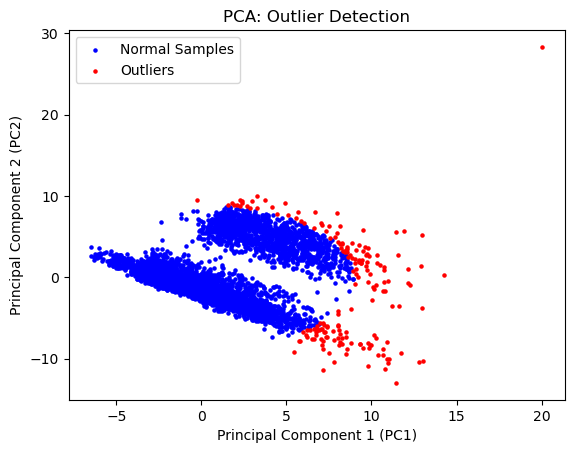

In [35]:
# Assuming you already have the 'outliers' DataFrame
normal_samples = df_temp_nasa.drop(outliers.index)  # Exclude outliers from normal samples

# Plotting the normal samples
plt.scatter(normal_samples['PC1'], normal_samples['PC2'], color='blue', label='Normal Samples', s=5)

# Plotting the outliers
plt.scatter(outliers['PC1'], outliers['PC2'], color='red', label='Outliers', s=5)

plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Outlier Detection')
plt.legend()
plt.show()

#### Remove all outliers

In [37]:
df_work = df_temp_nasa[df_temp_nasa['EuclideanDistance'] < 80].drop(['PC1', 'PC2', 'EuclideanDistance'], axis=1)

df_work

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
1,0.0,0.0,0.0,9.488036,170.538750,2455003.539,0.146,2.95750,615.8,0.022344,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,54.418383,162.513840,2454995.514,0.586,4.50700,874.8,0.027954,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,19.899140,175.850252,2455008.850,0.969,1.78220,10829.0,0.154046,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.736952,170.307565,2455003.308,1.276,2.40641,8079.2,0.387394,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,2.525592,171.595550,2455004.596,0.701,1.65450,603.3,0.024064,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9468,0.0,0.0,0.0,313.198750,340.937200,2455173.937,0.360,8.60300,721.0,0.024491,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9469,0.0,0.0,0.0,134.370692,249.313600,2455082.314,0.174,8.73000,432.6,0.019016,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9470,0.0,1.0,1.0,2.521230,132.870900,2454965.871,1.158,4.73900,145.9,0.170510,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9471,0.0,0.0,0.0,47.431486,174.654700,2455007.655,0.014,4.51100,172.8,0.011733,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


<a id='corr'></a>
## 4.5. Check for Correlated Features


In [38]:
corr_matrix = df_work.corr(method="pearson")
corr_matrix

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
StellarEclipseFalsePositiveFlag,1.000000,0.151329,0.101560,-0.019812,-0.112941,-0.112941,0.043530,0.033359,0.423975,0.035804,...,-0.182378,-0.051430,0.188867,-0.156318,-0.051430,0.188867,0.075200,0.159283,-0.158928,-0.043380
CentroidOffsetFalsePositiveFlag,0.151329,1.000000,0.525710,-0.019925,-0.119365,-0.119365,0.006659,-0.040173,-0.121656,-0.016683,...,-0.139487,-0.011638,0.129644,-0.123302,-0.011638,0.129644,0.046101,0.116579,-0.101262,-0.029346
EphemerisMatchIndicatesContaminationFalsePositiveFlag,0.101560,0.525710,1.000000,-0.016157,-0.094768,-0.094768,-0.003926,0.025758,-0.083711,-0.019622,...,-0.119168,0.006115,0.102175,-0.100807,0.006115,0.102175,0.015133,0.094571,-0.089369,-0.000026
OrbitalPeriod[days],-0.019812,-0.019925,-0.016157,1.000000,0.094196,0.094196,0.004866,0.037020,-0.009050,0.005077,...,0.074836,0.002193,-0.067390,0.038765,0.002193,-0.067390,-0.003368,-0.062991,0.075350,0.003796
TransitEpoch[BKJD],-0.112941,-0.119365,-0.094768,0.094196,1.000000,1.000000,0.049131,0.219688,-0.049036,0.056502,...,0.331002,0.008463,-0.297406,0.321162,0.008463,-0.297406,-0.027239,-0.271489,0.308250,0.023581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCEDelivery_q1_q17_dr25_tce,0.188867,0.129644,0.102175,-0.067390,-0.297406,-0.297406,-0.080732,-0.093682,0.090835,-0.091249,...,-0.846024,-0.470313,1.000000,-0.696846,-0.470313,1.000000,-0.003161,0.945088,-0.770782,-0.372304
StellarParameterProvenance_Solar,0.075200,0.046101,0.015133,-0.003368,-0.027239,-0.027239,0.027442,-0.007394,0.110669,0.030216,...,0.003560,0.000022,-0.003161,-0.009005,0.000022,-0.003161,1.000000,-0.235394,-0.035031,-0.016921
StellarParameterProvenance_q1_q17_dr25_stellar,0.159283,0.116579,0.094571,-0.062991,-0.271489,-0.271489,-0.079714,-0.087569,0.059384,-0.090019,...,-0.799567,-0.444487,0.945088,-0.658581,-0.444487,0.945088,-0.235394,1.000000,-0.728456,-0.351860
StellarParameterProvenance_stellar_q1_q16,-0.158928,-0.101262,-0.089369,0.075350,0.308250,0.308250,0.040814,0.095362,-0.085975,0.050633,...,0.820648,0.083515,-0.770782,0.686000,0.083515,-0.770782,-0.035031,-0.728456,1.000000,-0.052363


In [52]:
# select upper traingle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#select columns with coefficient of 0.95+ or -0.95- aka high negative/positive linear correlation
to_drop = [column for column in upper.columns if any(upper[column] >= 0.95) or any(upper[column] <= -0.95)]


C:\Users\Nareed\AppData\Local\Temp\ipykernel_17428\4245563772.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


<Axes: >

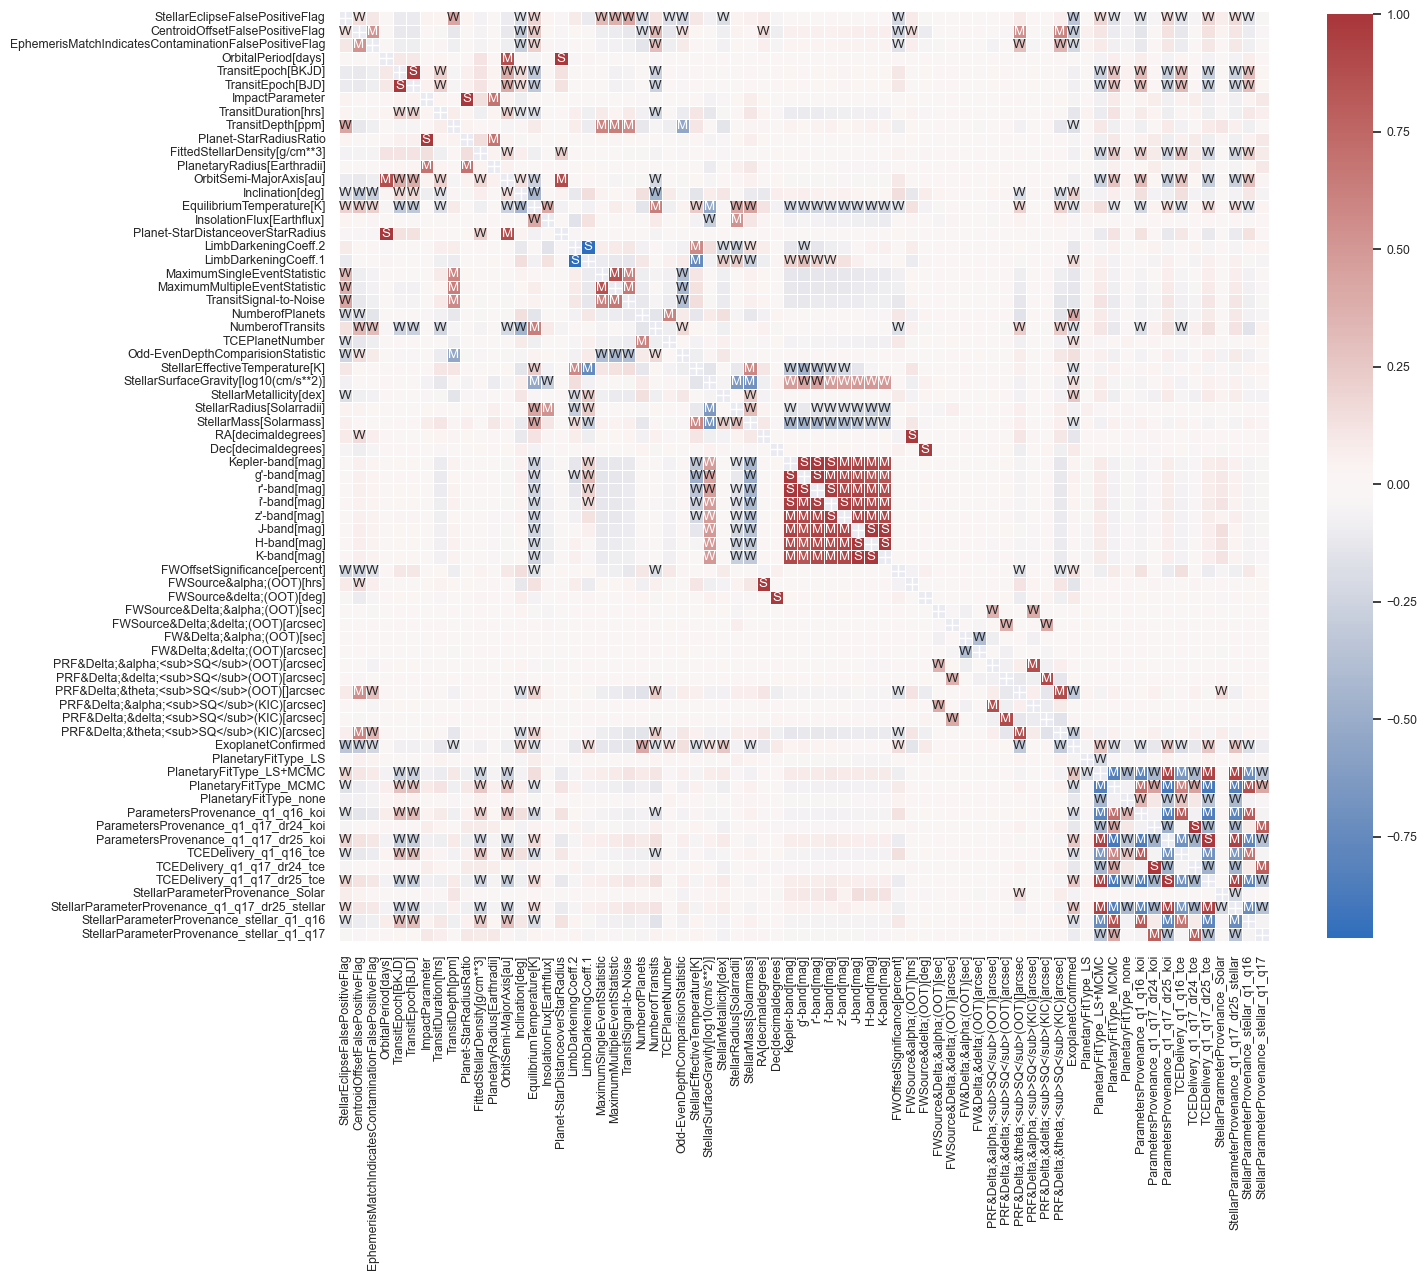

In [54]:
sns.set(font_scale=0.8)


# Create labels for the correlation matrix
labels = np.where(np.abs(corr_matrix)>0.95, "S",
                  np.where(np.abs(corr_matrix)>0.5, "M",
                           np.where(np.abs(corr_matrix)>0.15, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [56]:
# drop the outliers

df_work = df_work.drop(to_drop, axis=1)

df_work

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],FittedStellarDensity[g/cm**3],PlanetaryRadius[Earthradii],...,PlanetaryFitType_MCMC,PlanetaryFitType_none,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
1,0.0,0.0,0.0,9.488036,170.538750,0.146,2.95750,615.8,3.20796,2.26,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,54.418383,162.513840,0.586,4.50700,874.8,3.02368,2.83,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,19.899140,175.850252,0.969,1.78220,10829.0,7.29555,14.60,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.736952,170.307565,1.276,2.40641,8079.2,0.22080,33.46,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,2.525592,171.595550,0.701,1.65450,603.3,1.98635,2.75,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9468,0.0,0.0,0.0,313.198750,340.937200,0.360,8.60300,721.0,3.66013,1.95,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9469,0.0,0.0,0.0,134.370692,249.313600,0.174,8.73000,432.6,1.72489,1.95,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9470,0.0,1.0,1.0,2.521230,132.870900,1.158,4.73900,145.9,0.00740,9.68,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9471,0.0,0.0,0.0,47.431486,174.654700,0.014,4.51100,172.8,4.51074,8.83,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<a id='balance'></a>
## 4.6. Class Balancing


In [46]:
X = df_work.drop('ExoplanetConfirmed', axis=1)
y = df_work['ExoplanetConfirmed']

print('Original dataset shape %s' % Counter(y))

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 6576, 1.0: 2626})
Resampled dataset shape Counter({1.0: 6388, 0.0: 6388})


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

<a id='feature-selection'></a>
## 4.7. Feature Selection after SMOTE


In [48]:
feature_names = [f"feature {i}" for i in range(X_res.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [49]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

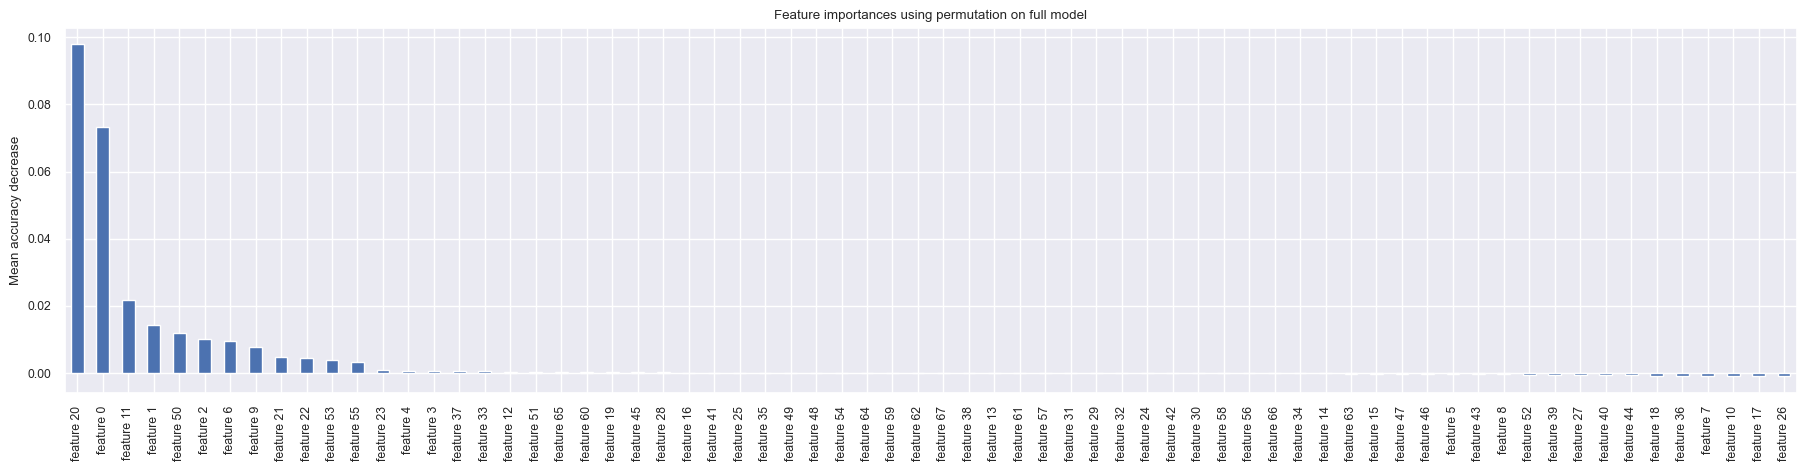

In [50]:
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figwidth(20)
plt.show()

In [51]:
importance_df = pd.DataFrame({'Feature': X_res.columns, 'Importance': forest_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

importance_threshold = 0.001

important_features = importance_df[importance_df['Importance'] >= importance_threshold]['Feature']
X_res_filtered = X_res[important_features]
X_res_filtered

,MaximumMultipleEventStatistic,StellarEclipseFalsePositiveFlag,PlanetaryRadius[Earthradii],CentroidOffsetFalsePositiveFlag,PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,EphemerisMatchIndicatesContaminationFalsePositiveFlag,ImpactParameter,Planet-StarRadiusRatio,TransitSignal-to-Noise,NumberofPlanets,PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PlanetaryFitType_LS+MCMC
0,28.470820,0.0,2.260000,0.0,0.200000,0.0,0.146000,0.022344,35.800000,2.000000,0.320000,1.0
1,20.109507,0.0,2.830000,0.0,0.390000,0.0,0.586000,0.027954,25.800000,2.000000,0.500000,1.0
2,187.449100,0.0,14.600000,0.0,0.042000,0.0,0.969000,0.154046,76.300000,1.000000,0.027000,1.0
3,541.895100,1.0,33.460000,0.0,0.289000,0.0,1.276000,0.387394,505.600000,1.000000,0.276000,1.0
4,33.191900,0.0,2.750000,0.0,0.100000,0.0,0.701000,0.024064,40.900000,1.000000,0.070000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12771,17.205372,0.0,1.437943,0.0,0.255953,0.0,0.281861,0.011487,20.326755,1.087792,0.240878,1.0
12772,21.858377,0.0,3.907215,0.0,0.273272,0.0,0.931396,0.037479,29.016261,2.000000,0.277459,1.0
12773,24.050607,0.0,3.562347,0.0,0.199460,0.0,0.891630,0.023348,27.622018,1.000000,0.455270,1.0
12774,13.990887,0.0,0.817454,0.0,0.504980,0.0,0.374928,0.007298,16.530574,1.000000,0.460307,1.0


------------------------------------------------------------------------------------------------------

<h2><b> Feature Importance </b></h2>

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = df_imputer_knn.drop('ExoplanetConfirmed', axis=1)
y = df_imputer_knn['ExoplanetConfirmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figwidth(20)
plt.show()

<h2><b> Class Imbalance </b></h2>

In [ ]:
data['ExoplanetConfirmed'].value_counts()

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 pyplot.scatter(X[:,0], X[:,1], label=str(label))
pyplot.legend()
pyplot.show()

------------------------------------------------------------------------------------------------------

<a id='model-building'></a>

## 5. Model Building
Next, we will build different machine learning models for exoplanet classification. Some of the models we can consider are:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machines (SVM)
5. Gradient Boosting

For each model, we will perform the following steps:
1. Initialize the model with default parameters.
2. Train the model on the training data.
3. Evaluate the model's performance using appropriate metrics.
4. Tune the hyperparameters if necessary.
------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------

<a id='model-evaluation'></a>

## 6. Model Evaluation
After building and tuning the models, we will evaluate their performance using various evaluation metrics such as accuracy, precision, recall, and F1-score. We will also visualize the results using confusion matrices and ROC curves.

------------------------------------------------------------------------------------------------------

<a id='conclusion'></a>

## 7. Conclusion

In conclusion, this project aims to classify exoplanets using machine learning techniques. By exploring the dataset, preprocessing the data, building and evaluating different models, we will gain insights into the classification of exoplanets and identify the most accurate model for exoplanet classification.

------------------------------------------------------------------------------------------------------

<a id='references'></a>

## 8. References

1. [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html)
2. Insert other references or resources used during the project.